# Assignment : Uber Supply-Demand Gap

## Problem Statement: Uber is facing a problem of  driver cancellation and non-availability of cars between City and Airport riders. This is leading to loss of potential revenue.
## As a data scientist we have to  identify the root cause of the problem (i.e. cancellation and non-availability of cars) and recommend ways to improve the situation.

In [1]:
#lets import the required libraries and load data for this assignment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
plt.style.context("default")

#let's load the data for this assignment into a dataframe GSDP_data

Uber_data = pd.read_csv('Uber Request Data.csv')

#check the datatypes
Uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB


In [2]:
#check null/Nan data in the Dataframe
Uber_data.isnull().sum(axis = 0)

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

In [3]:
#check no of records with status = 'Cancelled', 'No Cars Available'
Uber_data['Status'].isin(['Cancelled', 'No Cars Available']).sum()

3914

In [4]:
#check no of records with status = 'Cancelled', 'No Cars Available'
Uber_data[Uber_data['Status'] == 'No Cars Available'].shape[0]

2650

**So basically the 'Driver id' is null for status = 'No Cars Available'
Drop timestampis null for status 'Cancelled', 'No Cars Available', so we dont need to handled this missing data**

In [5]:
Uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


## lets Create derived variables which can be useful for further analysis

In [6]:
#Derive Request_date from 'Request timestamp'

#Uber_data['Request_dt'] = Uber_data['Request timestamp'].apply(lambda x: x.split(' ')[0]).apply(lambda x: x.replace('/','-')).apply(lambda x: pd.to_datetime(x)).dt.date
Uber_data['Request_dt'] = Uber_data['Request timestamp'].apply(lambda x: x.split(' ')[0]).apply(lambda x: x.replace('/','-')).apply(lambda x: x.replace('-7-','-07-'))
Uber_data['Request_dt'] = Uber_data['Request_dt'].apply(lambda x: pd.to_datetime(x, format='%d-%m-%Y')).dt.date


In [7]:
#Derive weekday name from 'Request timestamp'
Uber_data['Request_day'] = pd.to_datetime(Uber_data['Request timestamp'], errors='coerce').dt.weekday_name

In [8]:
#Derive Request Time from 'Request timestamp'
Uber_data['Request_time'] = Uber_data['Request timestamp'].apply(lambda x: x.split(' ')[1]).apply(lambda x: x.split(':')[0]).apply(lambda x: x.rjust(2,'0'))


In [9]:
#Derive drop_date from 'Drop timestamp'
  
Uber_data['Drop_date'] = pd.to_datetime(Uber_data['Drop timestamp'], errors='coerce').dt.date

In [10]:
#Derive drop_time from 'Drop timestamp'

Uber_data['Drop_time'] = pd.to_datetime(Uber_data['Drop timestamp'], errors='coerce').dt.hour

In [11]:
#Assign timeslots which can help us further analysis
def assign_timeslot(rt):
  if (rt >=23 or rt <= 3):
    return '1. Night'
  elif (rt > 3 and rt <= 7):
    return '2. Early Morning'
  elif (rt > 7 and rt <= 11):
    return '3. Late Morning'
  elif (rt > 11 and rt <= 15):
    return '4. Early Afternoon'
  elif (rt > 15 and rt <= 19):
    return '5. Early Evening'
  else:
    return '6. Late Evening'

In [12]:
Uber_data['Timeslot'] = Uber_data['Request_time'].apply(lambda x:assign_timeslot(int(x)) )

In [13]:
#check Unique trip status
Uber_data.Status.unique()

array(['Trip Completed', 'Cancelled', 'No Cars Available'], dtype=object)

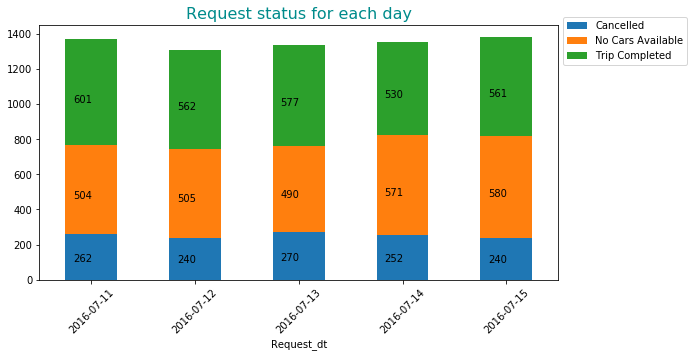

In [14]:
#lets check no of trips completed for each day as well as cancelled and unavailabity of cabs
ax = Uber_data.groupby(['Request_dt','Status']).size().reset_index().pivot(columns='Status', index='Request_dt', values=0).plot.bar(stacked=True,figsize = (8,5))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}'.format(height), (p.get_x()+.15*width, p.get_y()+.4*height))
plt.tight_layout()
plt.title("Request status for each day",fontsize= 16, color = 'darkcyan')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.xticks(rotation =45)
plt.show()

In [15]:
 Uber_data.groupby(['Request_dt','Status']).size().reset_index().pivot(columns='Status', index='Request_dt', values=0).mean()

Status
Cancelled            252.8
No Cars Available    530.0
Trip Completed       566.2
dtype: float64

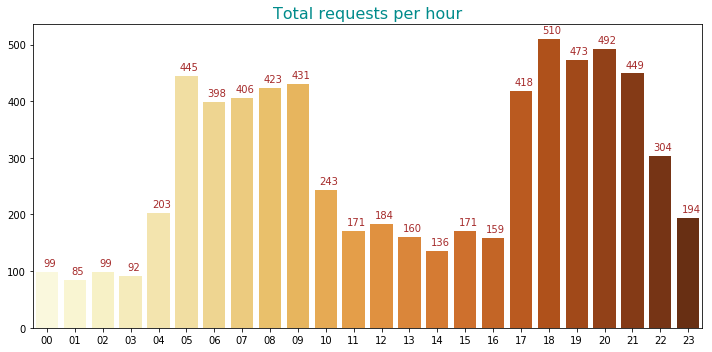

In [16]:
#plot all record showing total requests for each hour
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x = Uber_data['Request_time'].value_counts().sort_index().index, y = Uber_data['Request_time'].value_counts().sort_index().values ,palette="YlOrBr")
for p in ax.patches:
    ax.text(p.get_x()+.5, p.get_height()+10, \
            str(int(p.get_height())), fontsize=10,color='brown',ha= "center")
plt.title("Total requests per hour",fontsize= 16, color = 'darkcyan')
plt.tight_layout()
plt.show()

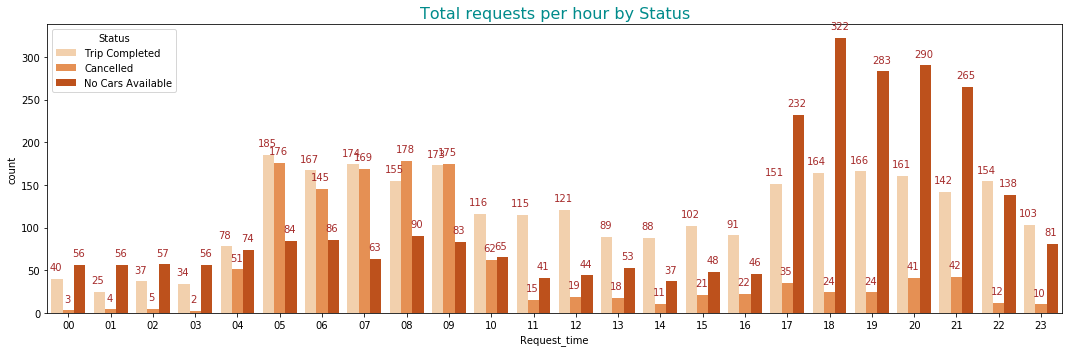

In [17]:
#plot all records showing total requests for each hour by status
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x = 'Request_time', hue =  'Status', data =Uber_data, palette  = "Oranges")
for p in ax.patches:
    ax.text(p.get_x()+.1, p.get_height()+10, \
            str(int(p.get_height())), fontsize=10,color='brown',ha= "center")
plt.title("Total requests per hour by Status",fontsize= 16, color = 'darkcyan')
plt.tight_layout()
plt.show()


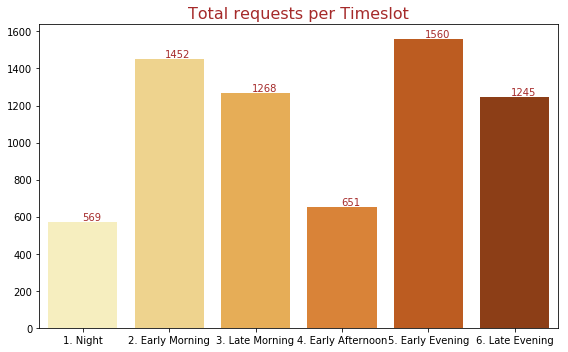

In [18]:
#plot all record showing total requests for each hour
f, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x = Uber_data['Timeslot'].value_counts().sort_index().index, y = Uber_data['Timeslot'].value_counts().sort_index().values ,palette="YlOrBr")
for p in ax.patches:
    ax.text(p.get_x()+.5, p.get_height()+10, \
            str(int(p.get_height())), fontsize=10,color='brown',ha= "center")
plt.title("Total requests per Timeslot",fontsize= 16, color = 'brown')
plt.tight_layout()
plt.show()

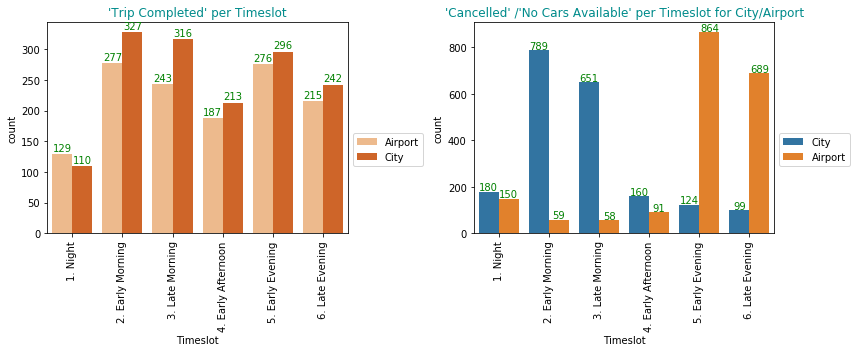

In [19]:
fig, (ax_5, ax_6) = plt.subplots(1,2,figsize=(12,5)) 

sns.countplot(x = 'Timeslot', hue = 'Pickup point', data =Uber_data[Uber_data['Status'].isin(['Trip Completed'])], palette  = "Oranges", order=['1. Night','2. Early Morning', '3. Late Morning', '4. Early Afternoon','5. Early Evening', '6. Late Evening'],ax = ax_5)
for p_5 in ax_5.patches:
    ax_5.text(p_5.get_x()+.2, p_5.get_height()+5, str(int(p_5.get_height())), fontsize=10,color='green',ha= "center")
ax_5.set_title("'Trip Completed' per Timeslot",fontsize= 12, color = 'darkcyan')
for tick in ax_5.get_xticklabels():
        tick.set_rotation(90)  
ax_5.legend(bbox_to_anchor=(1, 0.5))

sns.countplot(x = 'Timeslot', hue ='Pickup point', data =Uber_data[Uber_data['Status'].isin(['Cancelled', 'No Cars Available'])],order=['1. Night','2. Early Morning', '3. Late Morning', '4. Early Afternoon','5. Early Evening', '6. Late Evening'], ax = ax_6 )
for p_6 in ax_6.patches:
    ax_6.text(p_6.get_x()+.2, p_6.get_height()+5,str(int(p_6.get_height())), fontsize=10,color='green',ha= "center")
ax_6.set_title("'Cancelled' /'No Cars Available' per Timeslot for City/Airport",fontsize= 12, color = 'darkcyan')
    
ax_6.legend(bbox_to_anchor=(1, 0.5)) 
for tick in ax_6.get_xticklabels():
        tick.set_rotation(90)  
plt.tight_layout()


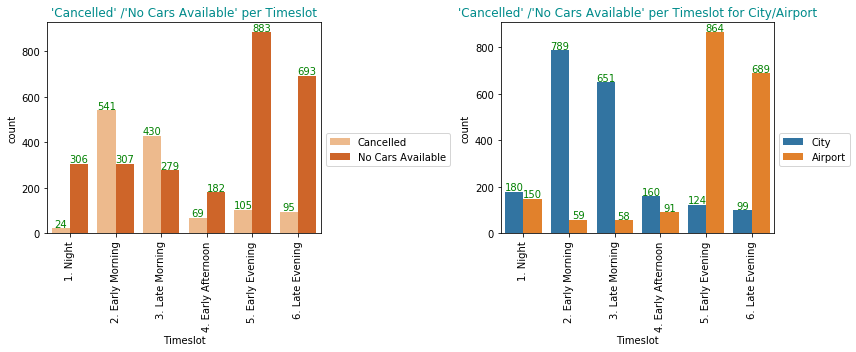

In [20]:
fig, (ax_5, ax_6) = plt.subplots(1,2,figsize=(12,5)) 

sns.countplot(x = 'Timeslot', hue =  'Status', data =Uber_data[Uber_data['Status'].isin(['Cancelled', 'No Cars Available'])], palette  = "Oranges", order=['1. Night','2. Early Morning', '3. Late Morning', '4. Early Afternoon','5. Early Evening', '6. Late Evening'],ax = ax_5)
for p_5 in ax_5.patches:
    ax_5.text(p_5.get_x()+.2, p_5.get_height()+5, str(int(p_5.get_height())), fontsize=10,color='green',ha= "center")
ax_5.set_title("'Cancelled' /'No Cars Available' per Timeslot",fontsize= 12, color = 'darkcyan')
for tick in ax_5.get_xticklabels():
        tick.set_rotation(90)  
ax_5.legend(bbox_to_anchor=(1, 0.5))

sns.countplot(x = 'Timeslot', hue ='Pickup point', data =Uber_data[Uber_data['Status'].isin(['Cancelled', 'No Cars Available'])],order=['1. Night','2. Early Morning', '3. Late Morning', '4. Early Afternoon','5. Early Evening', '6. Late Evening'], ax = ax_6 )
for p_6 in ax_6.patches:
    ax_6.text(p_6.get_x()+.2, p_6.get_height()+5,str(int(p_6.get_height())), fontsize=10,color='green',ha= "center")
ax_6.set_title("'Cancelled' /'No Cars Available' per Timeslot for City/Airport",fontsize= 12, color = 'darkcyan')
    
ax_6.legend(bbox_to_anchor=(1, 0.5)) 
for tick in ax_6.get_xticklabels():
        tick.set_rotation(90)  
plt.tight_layout()

 ## Observations:
 - **Its seems for City that number of cancelled requests are significant  in the early morning and late morning**
 - **Its seems that unavailability  of cars  are significant in the early and late morning for city location**
 - **At the Airport unavailability  of cars  is significant in the early and late evening**
 - **From night till late morning unavailability  of cars is same which can be addressed by increasing driver partners**
 - **Other than night, City location has more Trips completed**

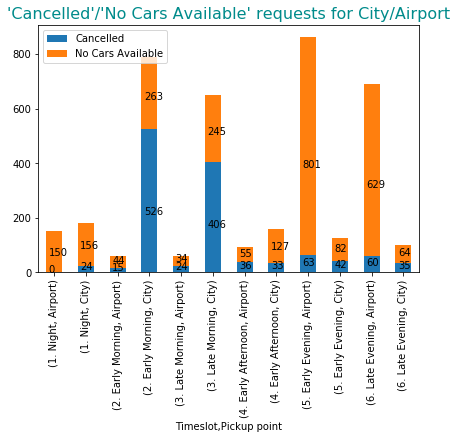

In [21]:
#Plot 'Cancelled'/'No Cars Available' requests for City/Airport
ax = Uber_data[Uber_data['Status'].isin(['Cancelled', 'No Cars Available'])].groupby(['Timeslot','Pickup point', 'Status']).size()\
.unstack().plot(kind = 'bar', stacked = True,figsize=(6, 6))
for p in ax.patches:                                                                                                                                               
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}'.format(height), (p.get_x()+.15*width, p.get_y()+.4*height))
plt.tight_layout()
plt.title("'Cancelled'/'No Cars Available' requests for City/Airport",fontsize= 16, color = 'darkcyan')
plt.legend(loc = 2)
plt.xticks(rotation =90)
plt.show()

**Observations:**

**For the Morning:**
  - **Car unavailability in city location is higher in the early and late morning**
  - **No. of cancelled requests in Morning are higher for City location, almost double than car availability in the morning**



**For the Evening**
  - **Car unavailability at Airport location is higher in the early and late evening**

**For the Night**
  - **For City  and Airport location number of cancellation and unavailability of cars is almost same and its significant**
  - **For Airport location number of cancellation is minimum**


In [22]:
df_uber_data = Uber_data.groupby(by =['Pickup point','Timeslot','Status'] )['Request id'].count().to_frame().reset_index()


In [23]:
uber_data_df = df_uber_data.pivot_table(index = ['Pickup point','Timeslot'], columns = 'Status', values = 'Request id' )

In [24]:
uber_data_df.loc['Airport'].head()

Status,Cancelled,No Cars Available,Trip Completed
Timeslot,,,
1. Night,NaN,150.0,129.0
2. Early Morning,15.0,44.0,277.0
3. Late Morning,24.0,34.0,243.0
4. Early Afternoon,36.0,55.0,187.0
5. Early Evening,63.0,801.0,276.0


## Calculate Demand Supply Gap
  - **Total Demand  = no of 'Cancelled' + no of 'No Cars Available' + no of 'Trip Completed'**
  - **Total supply = no of 'Trip Completed**
  - **Demand Supply Gap = no of 'Cancelled' + no of 'No Cars Available'**

In [25]:
#Calculate Total Demand
uber_data_df['Total_demand'] = uber_data_df['Cancelled'] + uber_data_df['No Cars Available'] + uber_data_df['Trip Completed']

In [26]:
#Calculate Total Supply
uber_data_df['Total_supply'] = uber_data_df['Trip Completed']

In [27]:
uber_data_df['Demand_Suppy_gap'] = uber_data_df['Cancelled'] + uber_data_df['No Cars Available'] 

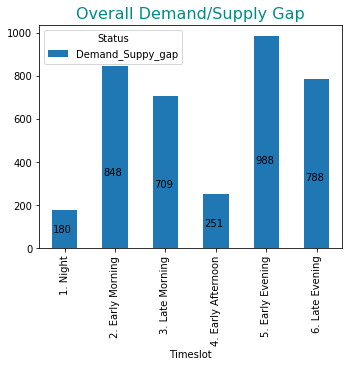

In [28]:
#Plot overall demand supply gap
ax = uber_data_df[['Demand_Suppy_gap']].groupby('Timeslot').sum().plot(kind = 'bar',figsize = (5,5))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}'.format(height), (p.get_x()+.05*width, p.get_y()+.4*height))
plt.tight_layout()
plt.title("Overall Demand/Supply Gap",fontsize= 16, color = 'darkcyan')
plt.show()

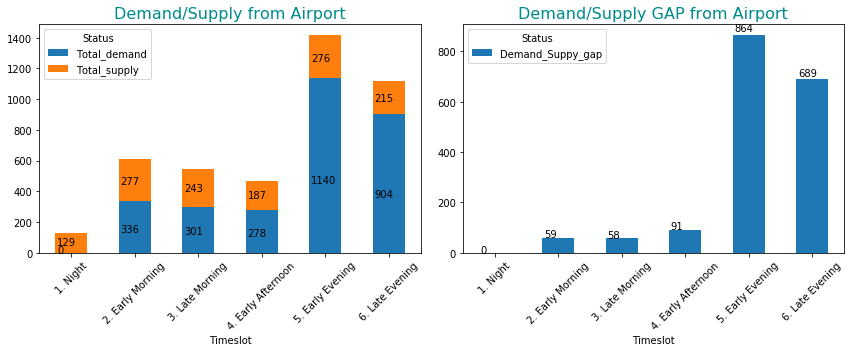

In [29]:
#Plot demand supply  from Airport
fig, (ax3, ax4) = plt.subplots(1,2)


ax3 = uber_data_df[['Total_demand','Total_supply']].loc['Airport'].plot(kind =  'bar',stacked=True,figsize = (12,5),ax = ax3)
for p3 in ax3.patches:
    width_3, height_3 = p3.get_width(), p3.get_height()
    x, y = p3.get_xy() 
    ax3.annotate('{:.0f}'.format(height_3), (p3.get_x()+.05*width_3, p3.get_y()+.4*height_3))
ax3.set_title('Demand/Supply from Airport',fontsize= 16, color = 'darkcyan')
for tick in ax3.get_xticklabels():
        tick.set_rotation(45)  

ax4 = uber_data_df[['Demand_Suppy_gap']].loc['Airport'].plot(kind =  'bar', stacked=True,figsize = (12,5),ax = ax4)
for p4 in ax4.patches:
    width_4, height_4 = p4.get_width(), p4.get_height()
    x, y = p4.get_xy() 
    ax4.annotate('{:.0f}'.format(height_4), (p4.get_x()+.05*width_4, p4.get_y()+1.02*height_4))
ax4.set_title('Demand/Supply GAP from Airport',fontsize= 16, color = 'darkcyan')
for tick in ax4.get_xticklabels():
        tick.set_rotation(45)  
plt.tight_layout()
plt.show()

**Observations:**
  - **Demand-Supply  gap is quite low in the early and late morning**
  - **Demand-Supply  gap is quite high in the early and late evening**
  - **Demand-Supply  gap is zero in the night**
  - **Ubers Supply is almost same at peak and off peak hours which is causing issues will lower supply for higher demand at peak hours**

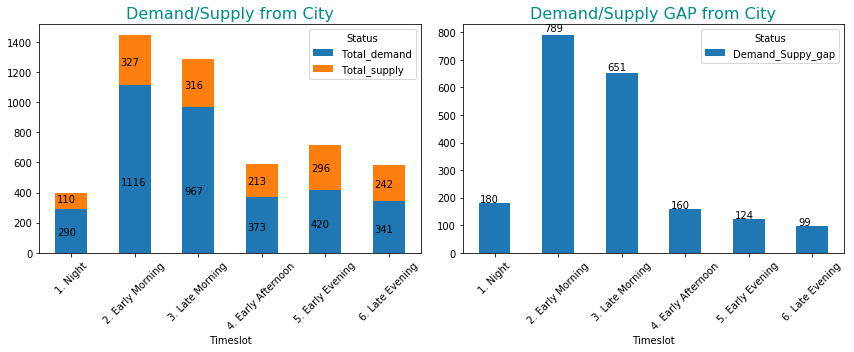

In [30]:
#Plot demand supply  from City
fig, (ax1, ax2) = plt.subplots(1,2)


ax1 = uber_data_df[['Total_demand','Total_supply']].loc['City'].plot(kind =  'bar',stacked=True,figsize = (12,5),ax = ax1)
for p1 in ax1.patches:
    width_1, height_1 = p1.get_width(), p1.get_height()
    x, y = p1.get_xy() 
    ax1.annotate('{:.0f}'.format(height_1), (p1.get_x()+.05*width_1, p1.get_y()+.4*height_1))
ax1.set_title('Demand/Supply from City',fontsize= 16, color = 'darkcyan')
for tick in ax1.get_xticklabels():
        tick.set_rotation(45)  

ax2 = uber_data_df[['Demand_Suppy_gap']].loc['City'].plot(kind =  'bar', stacked=True,figsize = (12,5),ax = ax2)
for p2 in ax2.patches:
    width_2, height_2 = p2.get_width(), p2.get_height()
    x, y = p2.get_xy() 
    ax2.annotate('{:.0f}'.format(height_2), (p2.get_x()+.05*width_2, p2.get_y()+1.02*height_2))
ax2.set_title('Demand/Supply GAP from City',fontsize= 16, color = 'darkcyan')
for tick in ax2.get_xticklabels():
        tick.set_rotation(45)  
plt.tight_layout()
plt.show()

**Observations:**
   - **Demand-Supply  gap is quite high in the early and late morning as well as in the Night**
   - **Ubers Supply is almost same at peak and off peak hours which is causing issues will lower supply for higher demand at peak hours**

## Check correlation between 'Cancelled','No Cars Available','Trip Completed'

In [31]:
uber_data_df[['Cancelled','No Cars Available','Trip Completed']].corr()

Status,Cancelled,No Cars Available,Trip Completed
Status,,,
Cancelled,1.000000,0.123682,0.605588
No Cars Available,0.123682,1.000000,0.153790
Trip Completed,0.605588,0.153790,1.000000


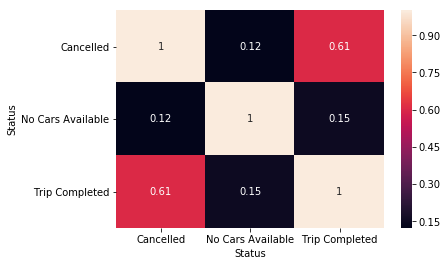

In [32]:
sns.heatmap(uber_data_df[['Cancelled','No Cars Available','Trip Completed']].corr(), annot= True)
plt.show()

**Can we check if specific drivers are cancelling the requests**

In [33]:
 Driver_trips = Uber_data[['Driver id','Status','Request id']].groupby(['Driver id','Status']).count().unstack()

In [34]:
#Check no of drivers in this dataset
Driver_trips.shape[0]

300

In [37]:
Driver_trips[Driver_trips[('Request id', 'Cancelled')] > 4].count()[0]

119

In [35]:
#no of drivers who have cancelled >= 4 trips
print('Cancelled trips by drivers (>=4) :', Driver_trips[Driver_trips[('Request id', 'Cancelled')] > 4].count()[0] )

canclled_trips = round(100* (Driver_trips[Driver_trips[('Request id', 'Cancelled')] > 4].count()[0])/Driver_trips.shape[0],2)
print('% of drivers who have cancelled >=4 trips {0}%'.format(canclled_trips) )

Cancelled trips by drivers (>=4) : 119
% of drivers who have cancelled >=4 trips 39.67%


**Observation:
around 40% have drivers cancelled >= 4 trips**


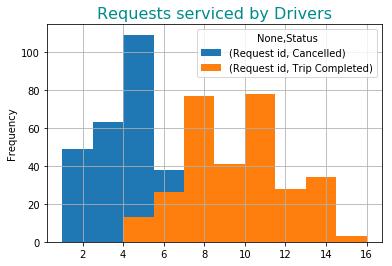

In [36]:
Driver_trips.plot.hist(grid=True, bins=10)
plt.title("Requests serviced by Drivers",fontsize= 16, color = 'darkcyan')
plt.show()

## Hypothesis :

**At city location we have noticed maximum cancellations in the morning**

**Root-cause:**

**if we look at the demand -supply gap, we can see that the demand supply gap at the Airport in the morning is low with negligible cancellation. 
The root cause for the cancellation at City can be fear of loosing time and money after the driver finishes the trip to the airport**





## Recommendations:
  - **For City location:**
     - Uber should increase supply at morning peak hours in the city to avoid cars unavailability 
     - Driver are cancelling trips in the morning in the city, which in turns causing uber revenue loss this has to be looked into.
     - Cars availability in the city is not proportional  to the demand, this need to be addressed.
     - Uber can look into providing some attractive perks to the drivers in the morning to reduce the cancellations.
  - **For Airport location:**
     - Uber should increase supply at evening peak hours at Airport to avoid cars unavailability 
     - Cars availability at Airport is not proportional to the demand, this need to be addressed.
     - To increase demand in the morning Uber can look into offering attractive  fares to the customers.
     
  - **Cancellation:**
      - There are around 40% of drivers who have cancelled >= 4 trips, this need to be looked into to understand the reasons behind the cancellation